## Network Simulation

In [13]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import itertools as itr
import warnings 
import seaborn as sns
import scipy as sp
from math import floor
%matplotlib inline
warnings.filterwarnings('ignore')

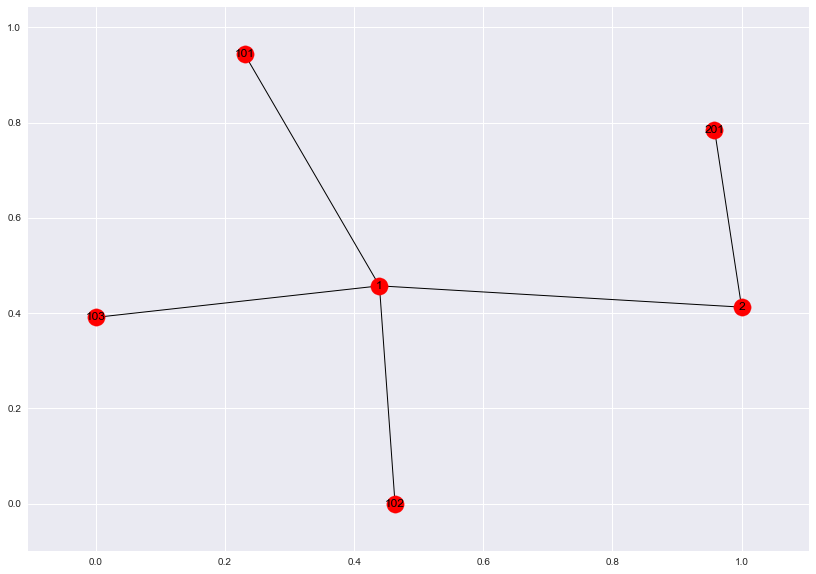

In [14]:
def draw_nw(num_of_hub, exp_spoke):
    
    num_of_spoke = np.random.normal(exp_spoke,1,num_of_hub)
    num_of_spoke = list(map(round, num_of_spoke))
    hub = list(range(1,num_of_hub+1))

    nw = nx.Graph()
    nw.add_nodes_from(hub, label = "Hub")
    hub_edges = np.array(list(itr.combinations(hub,2)))
    nw.add_edges_from(hub_edges, label = "Hub_edges")


    ##Assuming that customers cannot fly from a spoke to a spoke directly. They have to stop at a hub. 

    for i, h in enumerate(hub):
        num_of_s = int(num_of_spoke[i])
        spokes = [(h*100 + a) for a in range(1,num_of_s+1)]
        nw.add_nodes_from(spokes, label = "spokes of hub " + str(h) )
        edge_to_hub = [(h, s) for s in spokes ]
        nw.add_edges_from(edge_to_hub, label = "Spoke_edges" )
        
    return nw
nw = draw_nw(2,1)    
plt.figure(figsize = (14,10))
nx.draw_networkx(nw)
plt.show()

## Network Dataset Constructing

In [15]:
itin = np.array(list(itr.combinations(nx.nodes(nw),2)))

In [16]:
import pandas as pd
df_itin = pd.DataFrame({'itinenary': list(map(tuple, itin))})
df_itin.head(5)

,itinenary
0,"(1, 2)"
1,"(1, 101)"
2,"(1, 102)"
3,"(1, 103)"
4,"(1, 201)"


In [17]:
def clr(tup):
    a = tup[0]
    b = tup[1]
    if (a < 100 and b>= 100) or (a >= 100 and b < 100):
        return 'spoke-hub'
    elif a < 100 and b < 100:
        return 'hub-hub'
    elif a >= 100 and b >= 100:
        return 'spoke-spoke'

In [18]:
itin_type = list(map(clr, df_itin['itinenary']))
df_itin['type'] = itin_type

In [19]:
def path_len(G, tup):
    a = tup[0]
    b = tup[1]
    return nx.shortest_path_length(G,a,b)

paths = list(map(lambda x: path_len(nw, x), df_itin['itinenary']))

In [20]:
df_itin['length'] = paths

In [21]:
def price(row):
    #hub to spoke
    h_s_mean = 0.7
    h_s_var = 0.08
    
    #spoke to hub to spoke
    s_h1_s_mean = 0.9
    s_h1_s_var = 0.08
    
    #hub to hub
    h_h_mean = 1.0
    h_h_var = 0.1

    #hub to hub to spoke
    h_h_s_mean = 1.3
    h_h_s_var = 0.1
    
    #spoke to hub to hub to spoke
    s_h2_s_mean = 1.5
    s_h2_s_var = 0.1
     
    
    if row[1] == 'hub-hub':
        return np.random.lognormal(h_h_mean, h_h_var)*100
    elif row[2] == 2 and row[1] == 'spoke-spoke':
        return np.random.lognormal(s_h1_s_mean, s_h1_s_var)*100
    elif row[2] == 2 and row[1] == 'spoke-hub':
        return np.random.lognormal(h_h_s_mean, h_h_s_var)*100
    elif row[1] == 'spoke-hub':
        return np.random.lognormal(h_s_mean, h_s_var)*100
    elif row[2] == 3:
        return np.random.lognormal(s_h2_s_mean, s_h2_s_var)*100
    
    

In [22]:
df_itin['fare1'] = df_itin.apply(price, axis = 1)

In [23]:
s_h2_s = df_itin[df_itin.type == 'spoke-spoke'][df_itin.length == 3].fare1.mean()
s_h1_s = df_itin[df_itin.type == 'spoke-spoke'][df_itin.length == 2].fare1.mean()
h_s = df_itin[df_itin.type == 'spoke-hub'][df_itin.length == 1].fare1.mean()
h_h_s = df_itin[df_itin.type == 'spoke-hub'][df_itin.length == 2].fare1.mean()
h_h = df_itin[(df_itin.type == 'hub-hub')].fare1.mean()

print('The average fare (class1) of a hub to spoke is ', round(h_s, 2))
print('The average fare (class1) of a spoke to hub to spoke is ', round(s_h1_s, 2))
print('The average fare (class1) of a hub to hub is ', round(h_h, 2))
print('The average fare (class1) of a hub to hub to spoke is ', round(h_h_s, 2))
print('The average fare (class1) of a spoke to hub to hub to spoke is ', round(s_h2_s, 2))



The average fare (class1) of a hub to spoke is  196.66
The average fare (class1) of a spoke to hub to spoke is  238.37
The average fare (class1) of a hub to hub is  270.14
The average fare (class1) of a hub to hub to spoke is  373.42
The average fare (class1) of a spoke to hub to hub to spoke is  459.07


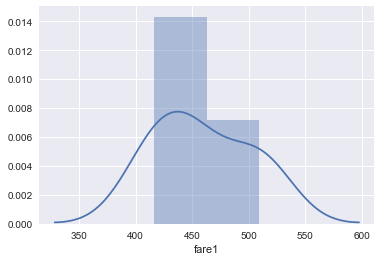

In [24]:
## Plot the price distritbution
sns.distplot(df_itin[df_itin.type == 'spoke-spoke'][df_itin.length == 3].fare1)

In [25]:
df_itin['fare2'] = df_itin['fare1']*1.5
df_itin['fare3'] = df_itin['fare1']*2.5

df_fare = df_itin[['fare1', 'fare2', 'fare3']]
df_itin.head(5)

,itinenary,type,length,fare1,fare2,fare3
0,"(1, 2)",hub-hub,1,270.138287,405.207431,675.345718
1,"(1, 101)",spoke-hub,1,203.326484,304.989727,508.316211
2,"(1, 102)",spoke-hub,1,181.467144,272.200716,453.667861
3,"(1, 103)",spoke-hub,1,203.344692,305.017037,508.361729
4,"(1, 201)",spoke-hub,2,348.564525,522.846787,871.411312


In [26]:
## constructing leg-itinenary matrix
itin_path = df_itin.itinenary

df_leg = df_itin[df_itin.length == 1]
df_leg.reset_index(drop = True, inplace = True)
df_leg.rename(columns = {'itinenary': 'leg'}, inplace = True)

leg_path = df_leg.leg

In [27]:
test = itin_path[6]
def leg_in_itin(itin, legs):
    a = itin[0]
    b = itin[1]
    
    short_paths = nx.shortest_path(nw, a, b)
    l1 = []
    for i in range(len(short_paths) -1 ):
        l1.append((short_paths[i],short_paths[i+1]))
        
    e = [0]*len(legs)
    for j in l1:
        e += (j == legs)*1

    return e


#leg_in_itin(itin_path[0], leg_path)
def E_df(leg_path, itin_path):
    m = np.matrix(list(map(lambda x: leg_in_itin(x, leg_path), itin_path)))
    df = pd.DataFrame(m, index = itin_path, columns = leg_path)
    return df
df_e = E_df(leg_path, itin_path)
df_full = pd.concat([df_itin, df_e.reset_index(drop = True)], axis = 1)

### Dataset notations: 
Columns：
- Itinenary: list of all itinenaries between every two nodes in the network
- Type: <br>
hub-hub -> itinenaries between two hubs <br>
spoke-hub -> itinenaries between two spoke and hub <br>
spoke-spoke -> itinenaries between two spokes <br>
- Fare i: Ticket Price for fare class i
- Flight legs (0-1 matrix): = 1 if leg i in itinenary j, and = 0, otherwise. 

In [28]:
df_full.head(8)

,itinenary,type,length,fare1,fare2,fare3,"(1, 2)","(1, 101)","(1, 102)","(1, 103)","(2, 201)"
0,"(1, 2)",hub-hub,1,270.138287,405.207431,675.345718,1,0,0,0,0
1,"(1, 101)",spoke-hub,1,203.326484,304.989727,508.316211,0,1,0,0,0
2,"(1, 102)",spoke-hub,1,181.467144,272.200716,453.667861,0,0,1,0,0
3,"(1, 103)",spoke-hub,1,203.344692,305.017037,508.361729,0,0,0,1,0
4,"(1, 201)",spoke-hub,2,348.564525,522.846787,871.411312,1,0,0,0,1
5,"(2, 101)",spoke-hub,2,374.662924,561.994386,936.657309,0,1,0,0,0
6,"(2, 102)",spoke-hub,2,384.067206,576.100809,960.168015,0,0,1,0,0
7,"(2, 103)",spoke-hub,2,386.385776,579.578664,965.964440,0,0,0,1,0


## Linear Program

\begin{equation*}
Maximize
\sum_{t \ \in \ T} 
\sum_{k \ \in \ K}
\sum_{j \ \in \ J}
f_{jk} \  
w_{jkt}
\end{equation*}

\begin{equation*}
Subject\ to:\ C_i - 
\sum_{s \ \in \ T}
\sum_{k \ \in \ K}
\mathbf{1}(s \leq t)
\sum_{j \ \in \ J}
w_{jkt} \ 
e_{ji} 
 \\ + 
\sum_{s \ \in \ T}
\sum_{k \ \in \ K}
\mathbf{1}(s \leq t - L)
(1-p)(1-\pi)
\sum_{j \ \in \ J}
w_{jkt} \ 
e_{ji} 
\geq 0
\, 
\forall \ i \ \in \ N
\ ,
\forall \ t \ \in \ T
\\
w_{jkt} 
\leq
\lambda_{jkt}
\\
\sum_{j \ \in J}
\sum_{k \ \in K}
\lambda_{jkt} = 1
\\
f_{jk} = p\ r_{jk} + (1 - p)\ (u + \pi\ r_{jk})
\end{equation*}

$f_{jk}:$ The expected revenue from itinenary j for fare class j. <br>
$w_{jkt}:$ (Decision variable) The probability that we will accept a request for itinenary j with fare class k at time t. <br>
$e_{ji}:$ If flight leg i in itinenary j, $e_{ji}$ = 1. Otherwise, $e_{ji}$ = 0 <br>
$C_{i}:$ Capacity of flight leg i. <br>
$\mathbf{1}:$ Decision function. $\mathbf{1}(a)$ = 1 if $a \leq 0$. $\mathbf{1}(a)$ = 0, otherwise. <br>
$\lambda_{jkt}$: The probability that a customer is insterest in itinenary j with fare class k at time t. <br>
$r_{jk}$: Ticket price for itinenary j with fare class k <br>

$T:$ All the time periods. <br>
$K:$ All the fare classes. <br>
$J:$ All the itinenaries. <br>
$N:$ All the flight legs. <br>
$L:$ The time a customer can lock for the fare. <br>
$p:$ Probability that a customer purchased a ticket directly. <br>
$1 - p:$ Probability that a customer locked a ticket. <br>
$\pi :$ Prabability that a customer finally bought the ticket that he locked <br>

In [29]:
## Assuming only one customer in each time interval
num_of_time = 20
num_of_class = 3
num_of_itin = len(itin_path)
num_of_leg = len(leg_path)

T = list(range(num_of_time))
K = list(range(num_of_class))
J = list(range(num_of_itin))
N = list(range(num_of_leg))

## Time to lock
L = floor(num_of_time*0.1)

## E[j][i] = 1 if leg i is in itinenary j
E = np.array(df_e)

## p: Probability that a customer purchased a ticket directly
## 1 - p: Probability that a customer locked a ticket
p = 0.5

#pi : Prabability that a customer finally bought the ticket that he locked
pi = 0.8

#R[j][k]: fare of itinenary j with fare class k
R = np.matrix(df_fare)

#u: fee for fare-locking
u = 20

## F[j][k]: expected revenue from itinenary j with fare class k
F = np.array(p*R + (1 - p)*(u + pi*R))

##lmd[j][k][t]: Probability of a customer interest in itinenary j with fare-class k at time t
##each time period, only one customer coming in interested in one itinenary and one class.   
lmd = np.array([[np.random.uniform(0.2, 1, num_of_time) for i in K] for j in J])

##Decision function
def one(a):
    if a:
        return 1
    else: 
        return 0

In [30]:
for t in T:
    s = lmd.sum(axis = 0).sum(axis = 0)[t]
    lmd[:,:,t] = lmd[:,:,t]/s
##check 
lmd.sum(axis = 0).sum(axis = 0)[5]

1.0

In [31]:
##Calculate ideal capacity
I = list(range(num_of_leg))
def idea_capa(i):
    I_i = 0
    for t in T:
        for j in J:
            for k in K:
                I_i += E[j][i]*lmd[j][k][t]
    return I_i
I = np.array(list(map(idea_capa, I)))     

In [32]:
##Calculate discounted capacity
C = (I*0.4).round().astype(int)
df_leg['capacity'] = C
df_leg.head()

,leg,type,length,fare1,fare2,fare3,capacity
0,"(1, 2)",hub-hub,1,270.138287,405.207431,675.345718,3
1,"(1, 101)",spoke-hub,1,203.326484,304.989727,508.316211,1
2,"(1, 102)",spoke-hub,1,181.467144,272.200716,453.667861,2
3,"(1, 103)",spoke-hub,1,203.344692,305.017037,508.361729,2
4,"(2, 201)",spoke-hub,1,198.487556,297.731333,496.218889,3


In [33]:
from gurobipy import *

In [34]:
model = Model("network")

## create decision variables 
W = [[[ 0 for t in T] for k in K ] for j in J]

for t in T:
    for k in K:
        for j in J:
            W[j][k][t] = model.addVar( vtype = GRB.CONTINUOUS, 
                                        name = "W_" + str(j) + "_" + str(k) + "_" + str(t))
            
model.update()

\begin{equation*}
Maximize
\sum_{t \ \in \ T} 
\sum_{k \ \in \ K}
\sum_{j \ \in \ J}
f_{jk} \  
w_{jkt}
\end{equation*}


In [35]:
## create a linear expression of the objective 
objExpr = LinExpr()
for t in T:
    for k in K:
        for j in J:
            objExpr += F[j][k] * W[j][k][t]
model.setObjective(objExpr, GRB.MAXIMIZE)

\begin{equation*}
\ C_i - 
\sum_{s \ \in \ T}
\sum_{k \ \in \ K}
\mathbf{1}(s \leq t)
\sum_{j \ \in \ J}
w_{jkt} \ 
e_{ji} 
+ 
\sum_{s \ \in \ T}
\sum_{k \ \in \ K}
\mathbf{1}(s \leq t - L)
(1-p)(1-\pi)
\sum_{j \ \in \ J}
w_{jkt} \ 
e_{ji} 
\geq 0
\ , 
\forall \ i \ \in \ N
\ ,
\forall \ t \ \in \ T
\end{equation*}


In [36]:
import time

In [37]:
t1 = time.time()

## create constraints for capacity
for t in T:
    for i in N:
        constExpr = LinExpr()
        for s in T:
            for k in K:
                for j in J:
                    constExpr += one(s <= t)*W[j][k][t]*E[j][i] + one(s <= t - L)*(1 - p)*(1 - pi)*W[j][k][t]*E[j][i]
        model.addConstr(lhs = constExpr, sense = GRB.LESS_EQUAL, rhs = C[i],
                        name = 'capacity_on_leg_' + str(i) + 'at_' + str(t))
    
model.update()
print(time.time() - t1)

4.554309129714966


\begin{equation*}
w_{jkt} 
\leq
\lambda_{jkt}
\end{equation*}

In [38]:
## create constraints for W
for t in T:
    for k in K:
        for j in J:
            descison_var = LinExpr()
            decision_var = W[j][k][t]
            
            bound = LinExpr()
            bound = lmd[j][k][t]
            
            model.addConstr(lhs = decision_var, sense = GRB.LESS_EQUAL, rhs = bound, 
                            name = 'prob_' + str(j)  + "_" + str(k) + "_" + str(t))
            
model.update()

In [39]:
## Write the model in a file
#model.write(filename = "testOutput3.lp")

In [40]:
## print optimal ojective and optimal solution
model.optimize()

Optimize a model with 1000 rows, 900 columns and 2040 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [2e+02, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-03, 3e+00]
Presolve removed 938 rows and 348 columns
Presolve time: 0.01s
Presolved: 62 rows, 552 columns, 696 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0486000e+04   1.349759e+01   0.000000e+00      0s
      79    7.8796313e+03   0.000000e+00   0.000000e+00      0s

Solved in 79 iterations and 0.03 seconds
Optimal objective  7.879631276e+03


In [41]:
## print optimal objective and optimal solution
print("\nOptimal Objedctive: " + str(model.Objval))
print("\nOptimal Solution(first 10):")
allVars = model.getVars()
for curVar in allVars[:10]:
    print(curVar.varname + " " + str(curVar.x)) 


Optimal Objedctive: 7879.631275771103

Optimal Solution(first 10):
W_0_0_0 0.01695983176332726
W_1_0_0 0.019769329538875228
W_2_0_0 0.009624253143414916
W_3_0_0 0.029075086739925676
W_4_0_0 0.02359016538530871
W_5_0_0 0.024245492710294126
W_6_0_0 0.009433994591560102
W_7_0_0 0.023855335386378348
W_8_0_0 0.008857697826344883
W_9_0_0 0.025209649652777784


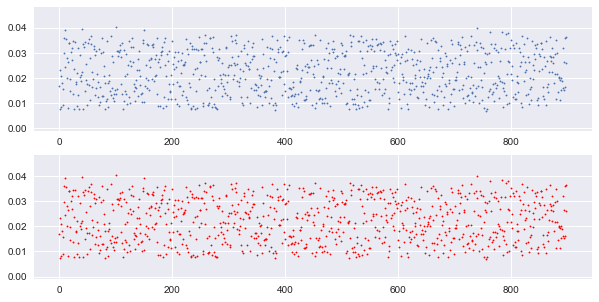

In [42]:
##plot the optimal probability 

w_dist = []
for curVar in allVars:
    w_dist.append(curVar.x)
lmd_dist = []
for j in J:
    for k in K:
        for t in T:
            lmd_dist.append(lmd[j][k][t])
            
##optimal vs constraints
##optimal in blue
##constraints in red

w_dist = np.array(w_dist)
w_dist = np.array(lmd_dist)

plt.figure(figsize = (10,5))  
plt.subplot(2,1,1)
plt.scatter(range(len(w_dist)), w_dist, s = 2)
plt.subplot(2,1,2)
plt.scatter(range(len(w_dist)), lmd_dist, s = 2, color = "red")

## Simulation

In [43]:
##convert optimal solution to matrix
W = w_dist.reshape(len(J), len(K), len(T))
W.shape

(15, 3, 20)

In [44]:
# np.save('W',W )
# np.save('lmd', lmd)

In [45]:
((w_dist - lmd_dist)!=0).sum()

0

In [46]:
from math import floor

def rand_lmd(lmd_at_t):
    lmd_at_t = np.array([lmd[j][k][t] for k in K for j in J])  ## construct lamda probs interval
    sum_lmd = np.array([lmd_at_t[:i].sum() for i in range(len(K)*len(J)+1)])
    a = np.random.uniform(0,1)
    pos = np.where(sum_lmd > a)[0][0] - 1
    i = floor(pos/len(K)) 

    c = pos%len(K) 

    return i, c

In [47]:
import copy

revenue = 0
Cap = C.copy()
Cap_path =[]
lock_path = []

for t in T:
    lmd_at_t = np.array([lmd[j][k][t] for k in K for j in J])  ## construct lamda probs interval
    i, c = rand_lmd(lmd_at_t)  ## random a itinenary and a class. i: index of itinenary. c: index of class
    if (Cap >= E[i]).sum() == len(Cap):
        prob_to_accept = W[i][c][t]/lmd[i][c][t]
        if np.random.binomial(1,prob_to_accept) == 1:  ## whether to accept or not
            Cap -= E[i]
            if np.random.binomial(1,p) == 1:           ## whether the customer buy to lock
                revenue += R[i,c]                     ## add revenue
                lock_path.append(0)
            else:
                revenue += u                           ## add revenue from locking fee
                lock_path.append(1)
                if t >= L:
                    if np.random.binomial(1,pi) == 1:      ## buy or leave
                        revenue += R[i,c]
                    elif lock_path[t-L] == 1:
                        Cap += E[i]
        else:
            lock_path.append(0)      
    else:
        lock_path.append(0)      
    Cap_path.append(Cap.copy())

In [48]:
revenue

3391.5397754727228

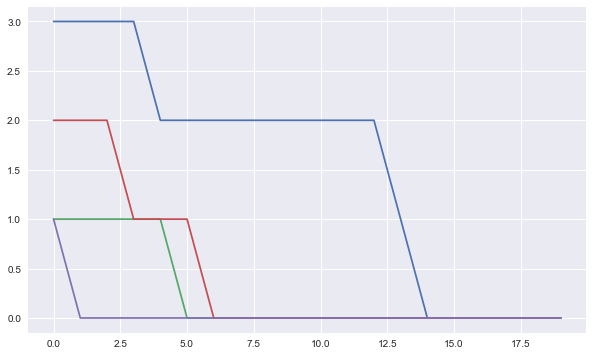

In [49]:
plt.figure(figsize= (10,6))
plt.plot(T, np.array(Cap_path)[:,0])
plt.plot(T, np.array(Cap_path)[:,1])
plt.plot(T, np.array(Cap_path)[:,2])
plt.plot(T, np.array(Cap_path)[:,3])